# Imagenet Processing in parallel

This notebook explores heavy data parallelization in reading, processing and modelling big data. Specifically, it implements the model from [DeViSE: A Deep Visual-Semantic Embedding Model](https://research.google.com/pubs/pub41869.html) on the entire [Imagenet](http://www.image-net.org) dataset.

## Setup

Load functions, libraries and set paths.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make help libraries available
import sys

sys.path.append('D:/anlaursen/libraries')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [290]:
import numpy as np
import json
import pickle
import nltk
import glob
import threading
import bcolz
import matplotlib.pyplot as plt
import re

from gensim.models import word2vec
from tqdm import tqdm
from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten
from keras.layers.pooling import AveragePooling2D
from keras.utils import get_file

import keras.backend as K

from kerastools.utils import BcolzArrayIterator
from kerastools.plot import autolabel, column_chart
from kerastools.resnet50 import Resnet50

from sklearn.neighbors import NearestNeighbors, LSHForest

Function parsing word2vec embeddings from string to numpy floats.

In [3]:
def parse_w2v(l):
    i = l.index(' ')
    return l[:i], np.fromstring(l[i + 1:-2], 'float32', sep = ' ')

Path to full data on spinning hard drive. We separate between sample and the full data set.

In [4]:
path = 'd:/anlaursen/data/imagenet/full/'
path = 'd:/anlaursen/data/imagenet/sample/'

Path to data on SSD

In [5]:
dpath = '/data/fast/imagenet/full/'
#dpath = '/data/fast/imagenet/sample/'

## Word vectors

First we need to grab some word vectors, to use as our dependent variable for the image model (so that the image vectors and word vectors will be in the same space). After loading the word vectors, we'll make sure that the names of the wordnet/imagenet are in the word list.

* Note that we do not follow the paper's approach - Here word2vec is better than custom skip-skip gram wikipedia vectors as word2vec has multi-word tokens like 'golden retriever'.
* We take the evaluations shown in this and other papers with a grain of salt, and do your our own tests on important bits. E.g. DeVISE (because it's an older paper) used an old and inaccurate image model, and poor word vectors, so recent papers that compare to it aren't so relevent

Specify word2vec path.

In [6]:
w2v_path = 'd:/anlaursen/data/word2vec/'

Initialise word2vec model and load pretrained embedding vectors from binary. Save these as text files.

In [9]:
model = word2vec.KeyedVectors.load_word2vec_format(w2v_path + 'GoogleNews-vectors-negative300.bin', binary = True)
model.save_word2vec_format(w2v_path + 'GoogleNews-vectors-negative300.txt', binary = False)

Read the word2vec embedding from text.

In [12]:
lines = open(w2v_path + '.txt', encoding = 'utf8').readlines()

Parse word2vec embeddings to a list of numpy floats

In [17]:
w2v_list = list(map(parse_w2v, lines[1:]))

Dump the processed word2vec embeddings as a pickle file for easier reading.

In [28]:
pickle.dump(w2v_list, open(w2v_path + 'w2vl.pkl', 'wb'))

Load word2vec embeddings from pickle file.

In [7]:
w2v_list = pickle.load(open(w2v_path + 'w2vl.pkl', 'rb'))

Finally construct a dict from the list and extract words and vectors.

In [8]:
w2v_dict = dict(w2v_list)

# Star before an itterator object unpacks it and returns the content.
words, vectors = zip(*w2v_list)

Test the validity of the data

In [9]:
print(np.corrcoef(w2v_dict['Andreas'], w2v_dict['Andreas']))
print(np.corrcoef(w2v_dict['andreas'], w2v_dict['Andreas']))
print(np.corrcoef(w2v_dict['banana'], w2v_dict['Andreas']))

[[ 1.  1.]
 [ 1.  1.]]
[[ 1.          0.18541016]
 [ 0.18541016  1.        ]]
[[ 1.          0.03458119]
 [ 0.03458119  1.        ]]


Use only lower case words as dictionary. Note that word2vec is ordered by how common a given word is. We can then go through the dictionary in reverse. As a dictionary cannot hold the same key twice, we will in the case of dual representation of a word end up with the more common one.

In [10]:
lc_w2v = {w.lower(): w2v_dict[w] for w in reversed(words)}

We're going to map word vectors for each of:

* The 1000 categories in the Imagenet competition
* The 82,000 nouns in [Wordnet](https://wordnet.princeton.edu/)

The idea being, that we want to go beyond imagenet and use the semantic meaning of the thousand images and be able to use the representations from there on the 82,000 nouns from wordnet. It is easy to map between the Wordnet and the Imagenet database as ImageNet is an image database organized according to the WordNet hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images.

We start by obtaining and passing the 1000 classes for imagenet.

In [11]:
# Path to classses
fpath = get_file('imagenet_class_index.json', 
                 'http://www.platform.ai/models/imagenet_class_index.json', 
                 cache_subdir = 'models')

# Parse json
class_dict = json.load(open(fpath))

# Number of classes
nclass = len(class_dict)

# Convert to dict
classids_1k = dict(class_dict.values())

nclass

1000

We then create the Wordnet Ids. Start by obtaining the Wordnet nouns.

In [12]:
wordnet_nouns = list(nltk.corpus.wordnet.all_synsets(pos = 'n'))
len(wordnet_nouns)

82115

Write offset and noun to file

In [18]:
with open(os.path.join(w2v_path, 'classids.txt'), 'w') as f:
    f.writelines(['n{:08d} {}\n'.format(n.offset(), n.name().split('.')[0]) for n in wordnet_nouns])

We then pass the Wordnet id mapping.

In [12]:
classid_lines = open(w2v_path + 'classids.txt', 'r').readlines()
classids = dict(l.strip().split() for l in classid_lines)

len(classids)

82115

Finally loop through the word2vec embeddings for each id for the imagenet classes and the wordnet ids and assign the given embedding to the given imagenet category.

In [13]:
syn_wv = [(k, lc_w2v[v.lower()]) for k, v in classids.items() if v.lower() in lc_w2v]
syn_wv_1k = [(k, lc_w2v[v.lower()]) for k, v in classids_1k.items() if v.lower() in lc_w2v]

# Convert to dict
syn2wv = dict(syn_wv)

len(syn_wv)

51640

And the items not matched

In [14]:
nomatch = [v[0] for v in class_dict.values() if v[0] not in syn2wv]
len(nomatch)

226

We then remove any folders that might not match.

In [16]:
nm_path = path + 'train_nm/'

if os.path.isdir(nm_path) == False:
    os.mkdir(nm_path)

for nm in nomatch:
    if os.path.isdir(path + 'train/' + nm):
        os.rename(path + 'train/' + nm, nm_path + nm)

Finally we can specify the number of dimensions, this being equal to the length of our word vectors.

In [15]:
ndim = len(list(syn2wv.values())[0])

ndim

300

## Resize images

Now that we've got our word vectors, we need a model that can create image vectors. It's nearly always best to start with a pre-train image model, and these require a specific size input. We'll be using resnet, which requires 224x224 sized images. Reading jpegs and resizing them can be slow, so we'll store the result of this.

First we create the filename list for the imagenet archive:

In [123]:
fnames_raw = list(glob.iglob(path + 'train/*/*.JPEG'))

# Replace windows style path formatting if needed
fnames = []
for f in fnames_raw:
    fnames.append(re.sub(r'\\', '/', f))

Even scanning a large collection of files is slow, so we save the filenames:

In [124]:
pickle.dump(fnames, open(path + 'fnames.pkl', 'wb'))

And load the file names

In [125]:
fnames = pickle.load(open(path + 'fnames.pkl', 'rb'))

We then randomise the names, such that we wont get the same item in each batch. We do this instead of shuffle to save read time. We get everything randomized, but in order, meaning that we don't have to jump to different places on the HDD.

In [126]:
fnames = np.random.permutation(fnames)

Dump that as well

In [40]:
pickle.dump(fnames, open(path + 'fnames_r.pkl', 'wb'))

And read

In [127]:
fnames = pickle.load(open(path+'fnames_r.pkl', 'rb'))

We then sepcify the height and width to resize to. This is rather lazy. It would propably be better to resize to something bitter and then to the final rezise by randomized zoom and crop.

In [128]:
new_s = 224

n = len(fnames)
n

19439

Set paths to resized images. This should be the path to an SSD for fast processing.

In [43]:
bc_path = path + 'trn_resized_224_r.bc'
#bc_path = f'{path}/results/trn_resized_{new_s}_r.bc'

There are three ways to speed up algorithms:

1. Memeory Locality: A memory hierarchy, where each level might improve performance 10-1000 fold. 
    a. L1 cache: 16K
    b. L2 cache: MB
    c. Ram: GB
    d. SSD: 100s GB
    e. HDD: TB
2. Simd - Single instruction, multiple data (i.e. vectorization): Calculate multiple things in the same thread.
3. Parellel processing: Distribute work across multiple threads.

Using pillow to resize the image (recommendation: install pillow-simd for 600% speedup). To install, force remove the conda installed version, then:

```
CC = "cc -mavx2" pip install -U --force-reinstall pillow-simd
```

Note that this does not work on Windows, where we have to rely on the old school Pillow :(

Define functions for resizing by resizing the small side of the image to the square and then crop off the larger side, ie. the centercropping apporach. Thus we avoid black border cropping and looding information.

In [44]:
def _resize(img):
    """
        Resize the image using center cropping.
    """
    shortest = min(img.width, img.height)
    resized = np.round(np.multiply(new_s / shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

def resize_img(i):
    """
        Open the image and resize it
    """
    img = Image.open(fnames[i])
    s = np.array(img).shape
    if len(s) != 3 or s[2] != 3: return
    return _resize(img)

def resize_img_bw(i):
    return _resize(Image.open(fnames[i]).convert('L'))

Pre-allocate memory in threadlocal storage. That is make a copy of a given object across each worker/thread used. This avoids locks and race conditions.

In [45]:
tl = threading.local()

# Create placeholder
tl.place = np.zeros((new_s,new_s,3), 'uint8')

Bcolz is amazingly fast, easy to use, and provides a largely numpy-compatible interface. It creates file-backed arrays and are transparently cached in memory.

Create (or open) compressed array for our resized images

In [154]:
arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), 
                   chunklen = 16, mode = 'w', rootdir = bc_path)

Function that appends resized image with black border added to longer axis

In [130]:
def get_slice(p, n):
    return slice((p-n+1) // 2, p - (p - n) // 2)

def app_img(r):
    # Append to a preallocated array
    tl.place[:] = (np.array(r)[get_slice(r.size[1], new_s), get_slice(r.size[0], new_s)] 
        if r else 0.)
    
    # Append to bcolz array
    arr.append(tl.place)

Serial version of resizing.

In [155]:
# Serial version
for i in range(n): app_img(resize_img(i))
arr.flush()

Parallel version of resizing

In [ ]:
# Parallel version

# Wrap in a for loop to visualise progress using tqdm
step = 6400
for i in tqdm(range(0, n, step)):
    
    # Create a threadpool with a given number of workers
    with ThreadPoolExecutor(max_workers = 16) as execr:
        
        # Map resizing across the image
        res = execr.map(resize_img, range(i, min(i + step, n)))
        
        # Append the results as they complete at each worker.
        for r in res: app_img(r)
            
    arr.flush()

Plot execution time

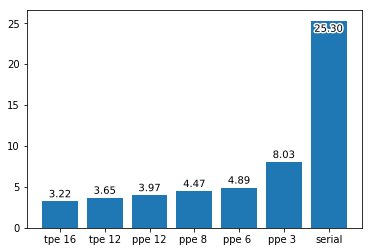

In [51]:
times = [('tpe 16', 3.22), ('tpe 12', 3.65), ('ppe 12', 3.97), ('ppe 8 ', 4.47), 
         ('ppe 6 ', 4.89), ('ppe 3 ', 8.03), ('serial', 25.3)]

column_chart(*zip(*times))

Open saved resized images

In [132]:
arr = bcolz.open(bc_path)

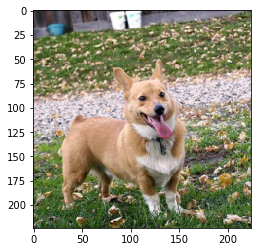

In [133]:
plt.imshow(arr[-2].astype('uint8'))

## Create model

Now we're ready to create our first model. Step one: create our target labels, which is simply a case of grabbing the synset id from the filename, and looking up the word vector for each.

In [156]:
def get_synset(f): return f[f.rfind('/') + 1:f.find('_')]

labels = list(map(get_synset, fnames))
labels[:5]

['n03372029', 'n07831146', 'n04285008', 'n02096051', 'n02028035']

So we can map the word embeddings across all labels

In [157]:
vecs = np.stack([syn2wv[l] for l in labels])
vecs.shape

(19439, 300)

We'll be using resnet as our model for these experiments

In [204]:
resnet = Resnet50(include_top = False)
model = resnet.model

Inspect model

In [205]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 224, 224, 3)   0           input_17[0][0]                   
____________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D) (None, 230, 230, 3)   0           lambda_8[0][0]                   
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_8[0][0]           
___________________________________________________________________________________________

____________________________________________________________________________________________________
activation_530 (Activation)      (None, 55, 55, 256)   0           add_173[0][0]                    
____________________________________________________________________________________________________
res3a_branch2a (Conv2D)          (None, 28, 28, 128)   32896       activation_530[0][0]             
____________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizatio (None, 28, 28, 128)   512         res3a_branch2a[0][0]             
____________________________________________________________________________________________________
activation_531 (Activation)      (None, 28, 28, 128)   0           bn3a_branch2a[0][0]              
____________________________________________________________________________________________________
res3a_branch2b (Conv2D)          (None, 28, 28, 128)   147584      activation_531[0][0]    

____________________________________________________________________________________________________
res3d_branch2c (Conv2D)          (None, 28, 28, 512)   66048       activation_541[0][0]             
____________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizatio (None, 28, 28, 512)   2048        res3d_branch2c[0][0]             
____________________________________________________________________________________________________
add_177 (Add)                    (None, 28, 28, 512)   0           bn3d_branch2c[0][0]              
                                                                   activation_539[0][0]             
____________________________________________________________________________________________________
activation_542 (Activation)      (None, 28, 28, 512)   0           add_177[0][0]                    
___________________________________________________________________________________________

activation_552 (Activation)      (None, 14, 14, 256)   0           bn4d_branch2a[0][0]              
____________________________________________________________________________________________________
res4d_branch2b (Conv2D)          (None, 14, 14, 256)   590080      activation_552[0][0]             
____________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizatio (None, 14, 14, 256)   1024        res4d_branch2b[0][0]             
____________________________________________________________________________________________________
activation_553 (Activation)      (None, 14, 14, 256)   0           bn4d_branch2b[0][0]              
____________________________________________________________________________________________________
res4d_branch2c (Conv2D)          (None, 14, 14, 1024)  263168      activation_553[0][0]             
___________________________________________________________________________________________

____________________________________________________________________________________________________
activation_563 (Activation)      (None, 7, 7, 2048)    0           add_184[0][0]                    
____________________________________________________________________________________________________
res5b_branch2a (Conv2D)          (None, 7, 7, 512)     1049088     activation_563[0][0]             
____________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizatio (None, 7, 7, 512)     2048        res5b_branch2a[0][0]             
____________________________________________________________________________________________________
activation_564 (Activation)      (None, 7, 7, 512)     0           bn5b_branch2a[0][0]              
____________________________________________________________________________________________________
res5b_branch2b (Conv2D)          (None, 7, 7, 512)     2359808     activation_564[0][0]    

In order to make each step faster, we'll save a couple of intermediate activations that we'll be using shortly. So we'll basically finetune in steps.

Renet utilises both identity and bottle neck blocks. The bottle neck blocks get thrown in to force the network to generate entire new features, where as identity block will tend to keep fine tuning existing feautures.

Should we then transfer learn from identity og bottle neck block, or before or after? No one has so far expiremented properly with this (and written a paper).

Intuitively, we should fine tune from layers just before a bottle neck, where the features have been fine tuned through all the previous identity blocks.

First, we grap the last layer before the final convolutional bottleneck. This is because our output is not to different from the output that the resnet model was trained on. That is Renet was trained on one hot encoded imagenet and we are also training on imagenet, but using word vectors, which is not to different.


In [206]:
# Keras does not name merge layers (at least not in this version), so grap the 
# previous layer
mid_start = model.get_layer('res5a_branch2a')

# And subtract the previous layer
mid_out = model.layers[model.layers.index(mid_start) - 1]
shp = mid_out.output_shape; shp

(None, 14, 14, 1024)

We put an average pooling layer on top to make it a more managable size

In [207]:
rn_top = Model(model.input, mid_out.output)
rn_top_avg = Sequential([rn_top, AveragePooling2D((7, 7))])

Inspect

In [208]:
shp = rn_top_avg.output_shape

shp

(None, 2, 2, 1024)

We create this intermediate array a batch at a time, so we don't have to keep it in memory. (2, 2, 1024) times a million is a lot of memory.

In [209]:
features_mid = bcolz.open(bc_path)

In [213]:
features_mid2 = bcolz.carray(np.empty((0,) + shp[1:]),
                            rootdir = path + 'results/features_mid_1c_r.bc',
                            chunklen = 16,
                            mode = 'w')

Define funtion to generate features. That is go through what is contained in the bcolz array a batch at a time.

In [214]:
def gen_features_mid(dirn):
    # Construct the generator with batch size 128
    gen = (features_mid[i:min(i + 128, n)] for i in range(0, len(features_mid), 128))
    
    # Loop through the batches
    for i, batch in tqdm(enumerate(gen)):
        
        # Append to the bcolz array the prediction of the given batch.
        features_mid2.append(rn_top_avg.predict(batch[:, :, ::dirn]))
        if (i % 100 == 99):
            
            # Write the results so far to disk
            features_mid2.flush()
    
    # Write the final results to disk
    features_mid2.flush()

Call with direction forward

In [215]:
gen_features_mid(1)


0it [00:00, ?it/s]
152it [02:13,  1.22it/s]


Call with direction backwards

In [216]:
gen_features_mid(-1)

152it [02:22,  1.10it/s]


And finally we get two copies of the images activations

In [217]:
features_mid2.shape

(38878, 2, 2, 1024)

Our final layers match the original resnet, although we add on extra resnet block at the top as well.

In [236]:
rn_bot_inp = Input(shp[1:])
x = rn_bot_inp

# Extra identity block
x = resnet.identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'f')
x = resnet.conv_block(x, 3, [512, 512, 2048], stage = 5, block = 'a')
x = resnet.identity_block(x, 3, [512, 512, 2048], stage = 5, block = 'b')
x = resnet.identity_block(x, 3, [512, 512, 2048], stage = 5, block = 'c')
x = Flatten()(x)

rn_bot = Model(rn_bot_inp, x)

rn_bot.output_shape

(None, 2048)

We set the weights using the pretrained resnet

In [240]:
for i in range(len(rn_bot.layers)-1):
    rn_bot.layers[-i-2].set_weights(model.layers[-i-1].get_weights())

We save this layer's results too, although it's smaller so should fit in RAM.

In [241]:
%time features_last = rn_bot.predict(features_mid2, batch_size = 128)

Wall time: 14.3 s


In [242]:
features_last = bcolz.carray(features_last,
                             rootdir = path + 'results/features_last_r.bc', 
                             chunklen = 64,
                             mode='w')

And open

In [243]:
features_last = bcolz.open(path + 'results/features_last_r.bc')[:]

We add a linear model on top to predict our word vectors as usual in transfer learning.

In [244]:
lm_inp = Input(shape = (2048,))

# No activation function, as we are trying to predict word vectors
lm = Model(lm_inp, Dense(ndim)(lm_inp))

Cosine distance is a good choice for anything involving nearest neighbors (which we'll use later).

It measures the angle rather than the distance between two vectors. In high dimensional space, distances are meaningless, as we are often on the edges of a given dimension. Thus everything is almost an equal distance from each other, but the angle will vary.

In [245]:
def cos_distance(y_true, y_pred):
    y_true = K.l2_normalize(y_true, axis = -1)
    y_pred = K.l2_normalize(y_pred, axis = -1)
    return K.mean(1 - K.sum((y_true * y_pred), axis = -1))

Compile

In [246]:
lm.compile('adam', 'cosine_proximity')

Concatenate labels

In [252]:
v = np.concatenate([vecs, vecs])

Evaluate

In [253]:
lm.evaluate(features_last, v, verbose = 0)

1.9026127478216423e-05

Fit

In [255]:
lm.fit(features_last, v, verbose = 2, epochs = 6)

Epoch 1/6
6s - loss: -1.5625e-03
Epoch 2/6
6s - loss: -1.5743e-03
Epoch 3/6
6s - loss: -1.5827e-03
Epoch 4/6
6s - loss: -1.5888e-03
Epoch 5/6
6s - loss: -1.5938e-03
Epoch 6/6
6s - loss: -1.5977e-03


Save intermediate weights, to avoid recalculating them

In [256]:
lm.save_weights(path + 'results/lm_cos.h5')

In [257]:
lm.load_weights(path + 'results/lm_cos.h5')

## Nearest Neighbors

Let's use nearest neighbors to look at a couple of examples, to see how well it's working. The first NN will be just looking at the word vectors of the 1,000 imagenet competition categories.

We will not get exact results, but the cosine distance between predictions and targets should be small. We can use a simple nearest neighbour model to do this.

We get the vectors

In [258]:
syns, wvs = list(zip(*syn_wv_1k))
wvs = np.array(wvs)

Fit nearest neighbor model, getting the three closest word vectors

In [261]:
# Brute force (N^2)
nn = NearestNeighbors(3, metric = 'cosine', algorithm = 'brute').fit(wvs)

In [262]:
# Approximate (NlogN)
nn = LSHForest(20, n_neighbors = 3).fit(wvs)

C:\Users\anlaursen\AppData\Loca\Anaconda3\envs\py3\lib\site-packages\sklearn\neighbors\approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


Run some images through our linear model

In [263]:
%time pred_wv = lm.predict(features_last[:10000])

Wall time: 2.8 s


And compute the distances using nearest neighbour

In [264]:
%time dist, idxs = nn.kneighbors(pred_wv)

Wall time: 48.6 s


For each image, what is the thing it thinks it might be

In [265]:
[[classids[syns[id]] for id in ids] for ids in idxs[190:200]]

[['barn', 'crate', 'boathouse'],
 ['sweatshirt', 'backpack', 'holster'],
 ['magnetic_compass', 'odometer', 'sundial'],
 ['soap_dispenser', 'saltshaker', 'coffeepot'],
 ['thimble', 'coffeepot', 'ringlet'],
 ['potpie', 'spaghetti_squash', 'consomme'],
 ['comic_book', 'burrito', 'cheeseburger'],
 ['forklift', 'canoe', 'tow_truck'],
 ['artichoke', 'spaghetti_squash', 'butternut_squash'],
 ['backpack', 'sweatshirt', 'bath_towel']]

And we can check and see if it fits.

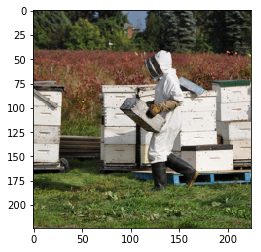

In [266]:
plt.imshow(arr[190].astype('uint8'))

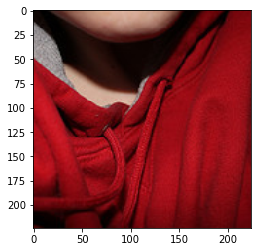

In [267]:
plt.imshow(arr[191].astype('uint8'))

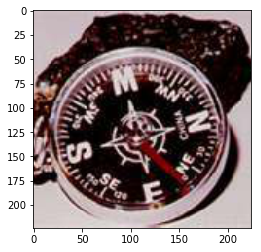

In [268]:
plt.imshow(arr[192].astype('uint8'))

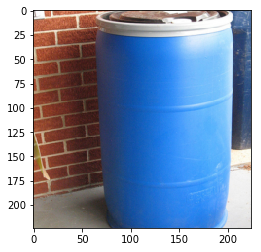

In [269]:
plt.imshow(arr[193].astype('uint8'))

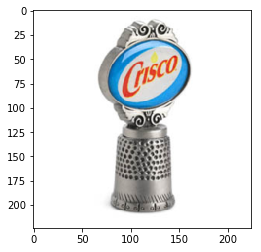

In [270]:
plt.imshow(arr[194].astype('uint8'))

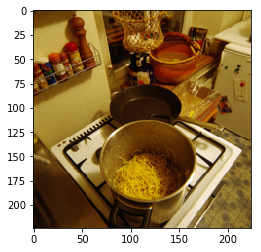

In [271]:
plt.imshow(arr[195].astype('uint8'))

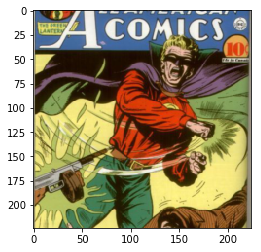

In [272]:
plt.imshow(arr[196].astype('uint8'))

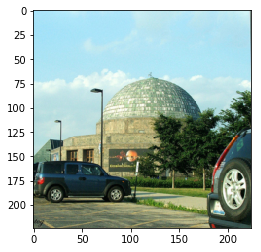

In [273]:
plt.imshow(arr[197].astype('uint8'))

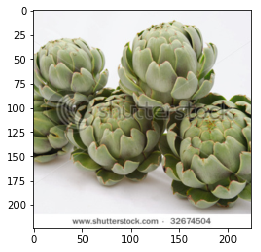

In [274]:
plt.imshow(arr[198].astype('uint8'))

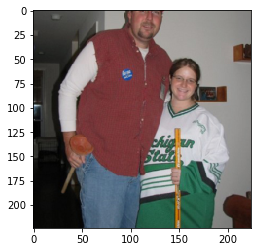

In [275]:
plt.imshow(arr[199].astype('uint8'))

A much harder task is to look up every wordnet synset id, but also more powerfull, as we can specify things not in imagenet.

In [276]:
all_syns, all_wvs = list(zip(*syn_wv))
all_wvs = np.array(all_wvs)

In [277]:
all_nn = LSHForest(20, n_neighbors=3).fit(all_wvs)

C:\Users\anlaursen\AppData\Loca\Anaconda3\envs\py3\lib\site-packages\sklearn\neighbors\approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [278]:
%time dist, idxs = all_nn.kneighbors(pred_wv[:200])

Wall time: 17.6 s


In [279]:
[[classids[all_syns[id]] for id in ids] for ids in idxs[190:200]]

[['barn', 'barn', 'hay_bale'],
 ['jacket', 'jacket', 'jacket'],
 ['prairie_rattlesnake', 'trilobite', 'northern_shrike'],
 ['loofa', 'oilcan', 'soap_dispenser'],
 ['darning_needle', 'needlenose_pliers', 'allen_wrench'],
 ['anchovy_paste', 'horseradish_sauce', 'bleu_cheese_dressing'],
 ['comic_book', 'lemon_meringue_pie', 'steamed_pudding'],
 ['sundew', 'barge', 'lightship'],
 ['clethra', 'guinea_hen', 'guinea_hen'],
 ['potholder', 'backpack', 'wristlet']]

## Fine tune

To improve things, let's fine tune more layers.

In [283]:
lm_inp2 = Input(shape = (2048,))

# Again no activation
lm2 = Model(lm_inp2, Dense(ndim)(lm_inp2))

Set the weights of the new model equal to the the weights of the old model

In [284]:
for l1, l2 in zip(lm.layers, lm2.layers): l2.set_weights(l1.get_weights())

Define and run model

In [285]:
rn_bot_seq = Sequential([rn_bot, lm2])
rn_bot_seq.compile('adam', 'cosine_proximity')
rn_bot_seq.output_shape

(None, 300)

The model is to big to fit in ram, so we use an itterator and serve the model batches of the data.

In [288]:
bc_it = BcolzArrayIterator(features_mid2, v, shuffle = True, batch_size = 128)

Set learning rate

In [291]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-3)

Run model

In [296]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose = 2, epochs = 4)

Epoch 1/4
2135s - loss: -3.1589e-03
Epoch 2/4
2132s - loss: -3.2052e-03
Epoch 3/4
2134s - loss: -3.2163e-03
Epoch 4/4
2135s - loss: -3.2235e-03


Lower learning rate

In [297]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-4)

In [298]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose = 2, epochs = 8)

Epoch 1/8
2133s - loss: -3.2313e-03
Epoch 2/8
2133s - loss: -3.2323e-03
Epoch 3/8
2134s - loss: -3.2327e-03
Epoch 4/8
2130s - loss: -3.2329e-03
Epoch 5/8
2126s - loss: -3.2333e-03
Epoch 6/8
2121s - loss: -3.2338e-03
Epoch 7/8
2122s - loss: -3.2343e-03
Epoch 8/8
2123s - loss: -3.2358e-03


Lower learning rate

In [299]:
K.set_value(rn_bot_seq.optimizer.lr, 1e-5)

In [300]:
rn_bot_seq.fit_generator(bc_it, bc_it.N, verbose = 2, epochs = 5)

Epoch 1/5
2123s - loss: -3.2373e-03
Epoch 2/5
2124s - loss: -3.2377e-03
Epoch 3/5
2121s - loss: -3.2380e-03
Epoch 4/5
2125s - loss: -3.2384e-03
Epoch 5/5
2122s - loss: -3.2389e-03


Evalutate model

In [302]:
rn_bot_seq.evaluate(features_mid2, v, verbose = 2)

-0.0032415047943565433

Save model

In [303]:
rn_bot_seq.save_weights(path + 'results/rn_bot_seq_cos.h5')

In [304]:
rn_bot_seq.load_weights(path + 'results/rn_bot_seq_cos.h5')

## KNN again

We then run the K nearest neightbours model again.

In [306]:
%time pred_wv = rn_bot_seq.predict(features_mid2)

Wall time: 21.7 s


Choose same slice as earlier

In [307]:
rng = slice(190, 200)

Run predictions on K nearest neighbors for just the imagenet words

In [308]:
dist, idxs = nn.kneighbors(pred_wv[rng])

And results

In [309]:
[[classids[syns[id]] for id in ids] for ids in idxs]

[['apiary', 'weevil', 'nematode'],
 ['sweatshirt', 'ski_mask', 'backpack'],
 ['magnetic_compass', 'chiton', 'mouse'],
 ['barrel', 'tank', 'crate'],
 ['thimble', 'beaker', 'cocktail_shaker'],
 ['carbonara', 'guacamole', 'dungeness_crab'],
 ['comic_book', 'cinema', 'goblet'],
 ['planetarium', 'projector', 'library'],
 ['artichoke', 'cauliflower', 'bell_pepper'],
 ['plunger', 'strainer', 'wallaby']]

An predictions on all wordnet words

In [310]:
dist, idxs = all_nn.kneighbors(pred_wv[rng])

In [311]:
[[classids[all_syns[id]] for id in ids] for ids in idxs]

[['apiary', 'citrus', 'citrus'],
 ['sweatshirt', 'shirt', 'jacket'],
 ['magnetic_compass', 'sextant', 'sextant'],
 ['barrel', 'barrel', 'barrel'],
 ['thimble', 'thimble', 'saucer'],
 ['carbonara', 'manicotti', 'osso_buco'],
 ['comic_book', 'novelette', 'cartoonist'],
 ['planetarium', 'planetarium', 'planetarium'],
 ['artichoke', 'artichoke', 'eggplant'],
 ['plunger', 'nozzle', 'putty_knife']]

Compare to images

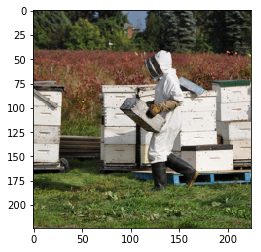

In [313]:
plt.imshow(arr[rng][0].astype('uint8'))

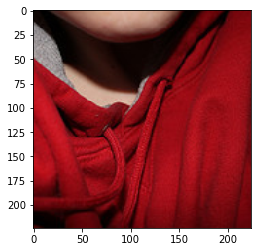

In [320]:
plt.imshow(arr[rng][1].astype('uint8'))

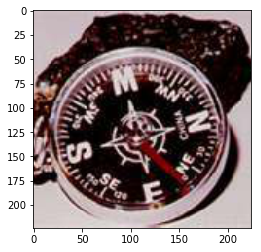

In [321]:
plt.imshow(arr[rng][2].astype('uint8'))

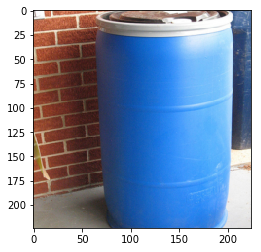

In [322]:
plt.imshow(arr[rng][3].astype('uint8'))

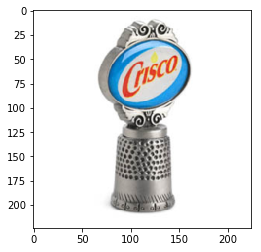

In [323]:
plt.imshow(arr[rng][4].astype('uint8'))

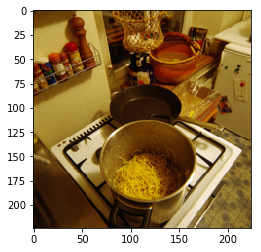

In [324]:
plt.imshow(arr[rng][5].astype('uint8'))

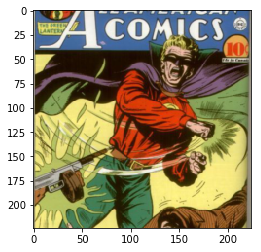

In [326]:
plt.imshow(arr[rng][6].astype('uint8'))

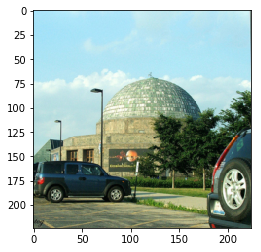

In [330]:
plt.imshow(arr[rng][7].astype('uint8'))

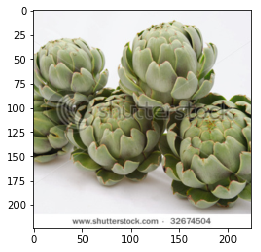

In [331]:
plt.imshow(arr[rng][8].astype('uint8'))

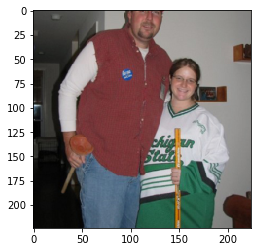

In [332]:
plt.imshow(arr[rng][9].astype('uint8'))

## Text -> Image

Something very nice about this kind of model is we can go in the other direction as well - find images similar to a word or phrase! So we fit the nearest neightbor model on our predictions.

In [333]:
img_nn = NearestNeighbors(3, metric='cosine', algorithm='brute').fit(pred_wv)

In [334]:
img_nn2 = LSHForest(20, n_neighbors=3).fit(pred_wv)

C:\Users\anlaursen\AppData\Loca\Anaconda3\envs\py3\lib\site-packages\sklearn\neighbors\approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


And find the image closest to violin

In [350]:
word = 'violin'
vec = w2v_dict[word]
# dist, idxs = img_nn.kneighbors(vec.reshape(1,-1))
dist, idxs = img_nn2.kneighbors(vec.reshape(1,-1))

And display the result

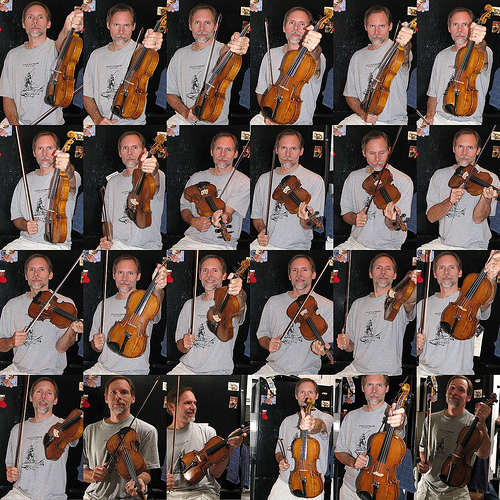

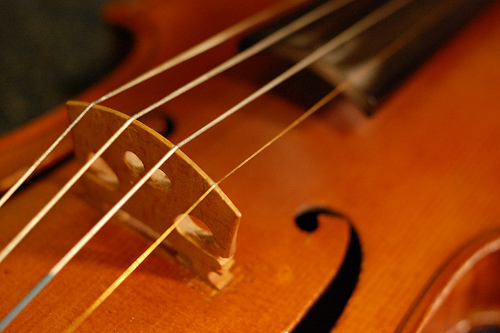

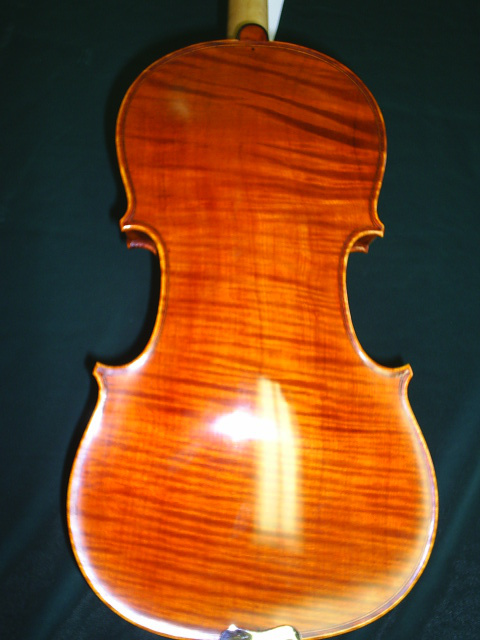

In [351]:
ims = [Image.open(fnames[fn%n]) for fn in idxs[0]]
display(*ims)

We can now also do algebra on the results and comvine two vectors

In [364]:
vec = (w2v_dict['violin'] + w2v_dict['instruments'])/2
dist, idxs = img_nn.kneighbors(vec.reshape(1,-1))

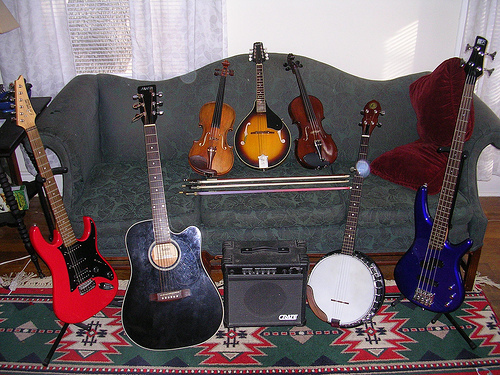

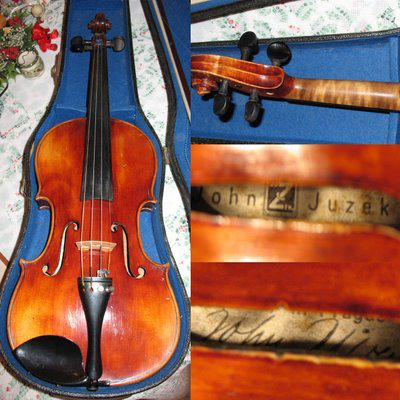

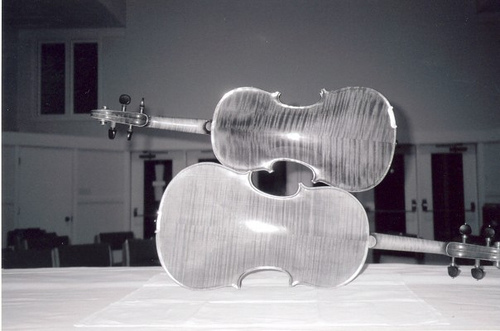

In [365]:
ims = [Image.open(fnames[fn%n]) for fn in idxs[0]]
display(*ims)

In [367]:
def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0: return low
    elif val >= 1: return high
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

In [368]:
vec = slerp(0.5, w2v_dict['paddle'], w2v_dict['boat'])
dist, idxs = img_nn.kneighbors(vec.reshape(1,-1))

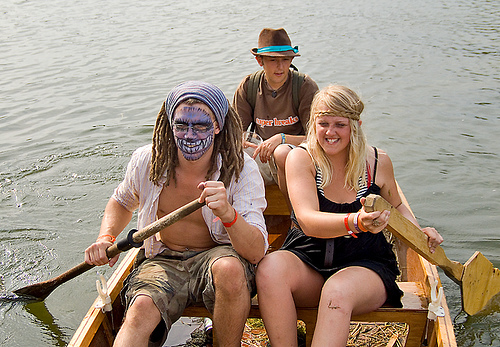

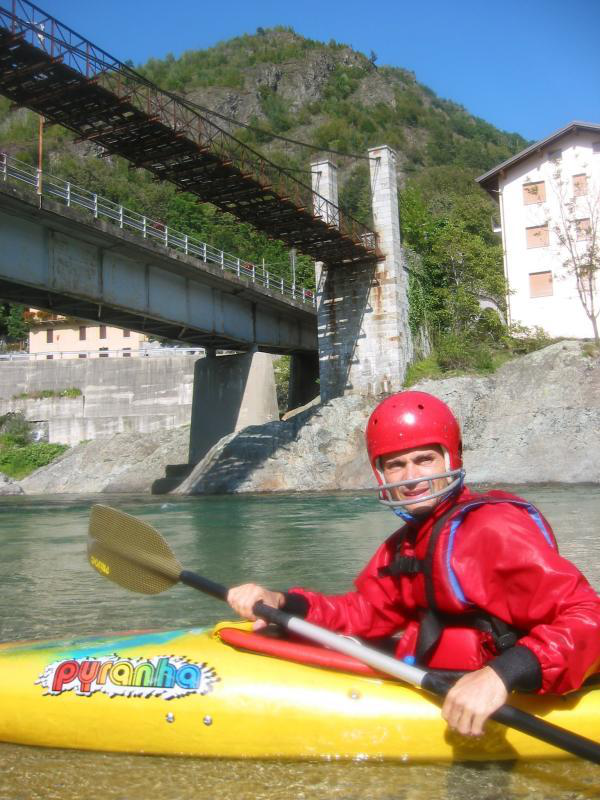

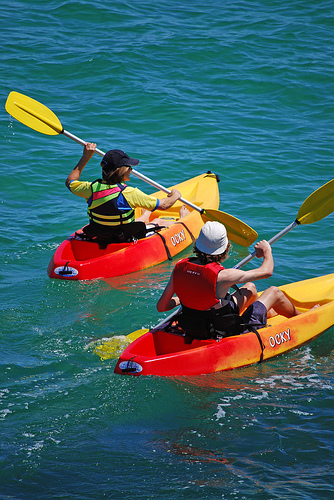

In [369]:
ims = [Image.open(fnames[fn%n]) for fn in idxs[0]]
display(*ims)

## Image -> Image

Since that worked so well, let's try to find images with similar content to another image...

Join the middle and end model

In [370]:
ft_model = Sequential([rn_top_avg, rn_bot_seq])

Get a image - Should really be from a validation set

In [379]:
new_file = 'D:/anlaursen/data/imagenet/sample/train/n02747177/n02747177_6429.JPEG'

Show image

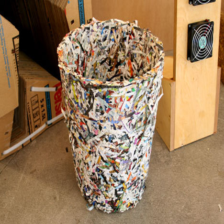

In [380]:
new_im = Image.open(new_file).resize((224,224), Image.BILINEAR); new_im

Get vector for the new image

In [381]:
vec = ft_model.predict(np.expand_dims(new_im, 0))

Run nearest neighbor

In [382]:
dist, idxs = img_nn2.kneighbors(vec)

Display top three nearest images.

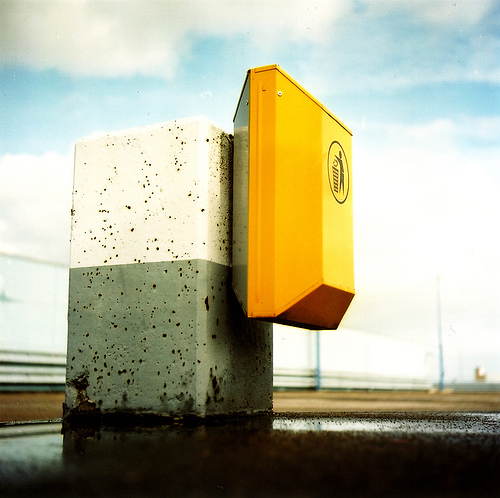

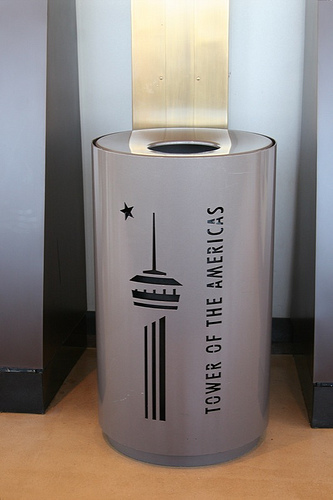

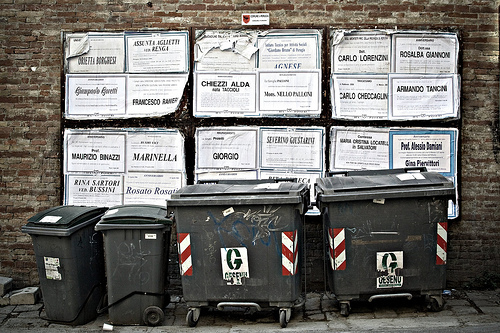

In [383]:
ims = [Image.open(fnames[fn%n]) for fn in idxs[0]]
display(*ims)